In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/moshida/EUVlitho


In [2]:
import numpy as np
from elitho import diffraction_amplitude, const, descriptors, diffraction_order, source

dod_narrow = descriptors.DiffractionOrderDescriptor(1.5)
dod_wide = descriptors.DiffractionOrderDescriptor(6.0)
doc_narrow = diffraction_order.DiffractionOrderCoordinate(
        dod_narrow.max_diffraction_order_x,
        dod_narrow.max_diffraction_order_y,
        diffraction_order.ellipse,
)
doc_wide = diffraction_order.DiffractionOrderCoordinate(
        dod_wide.max_diffraction_order_x,
        dod_wide.max_diffraction_order_y,
        diffraction_order.rounded_diamond,
)

/home/moshida/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from elitho.pupil import PupilCoordinates
pupil_coords = PupilCoordinates(doc_wide.num_valid_diffraction_orders)
pupil_coords.n_coordinates, np.sum(pupil_coords.xinput >= 8)


(333, np.int64(241))

In [4]:
# dkx, dky, SDIV = source.uniform_k_source()
uniform_k_source = source.UniformKSource()

In [5]:
amp_absorber, amp_vacuum, phasexx = diffraction_amplitude.zero_order_amplitude(const.PolarizationDirection.X, dod_wide, doc_narrow)

/home/moshida/EUVlitho/elitho/diffraction_amplitude.py:163: RuntimeWarning: invalid value encountered in scalar divide
  phasexx[x, y] = vcxx[x, y] / np.abs(vcxx[x, y])


In [6]:
from elitho.mask_pattern import LinePattern
from elitho import const
mask = LinePattern(cd=80, gap=60, direction="V", field_type="DF")(const.NDIVX, const.NDIVY)

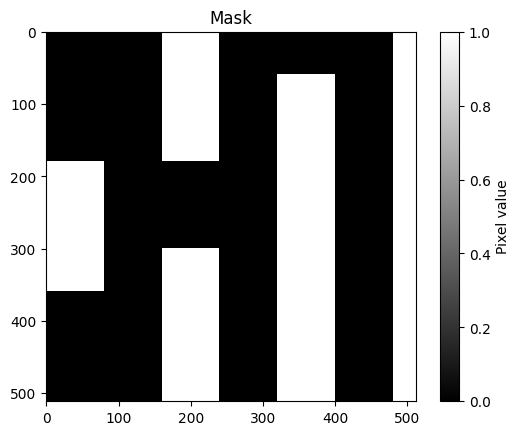

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(mask, cmap='gray', interpolation='nearest')
plt.title("Mask")
plt.colorbar(label="Pixel value")
plt.show()

In [8]:
hfpattern = mask * (amp_absorber - amp_vacuum) + amp_vacuum

In [9]:
# fft with scaling
fft_mask = np.fft.fft2(hfpattern, norm="forward")

In [10]:
fft_mask.shape, const.noutX, const.noutY

((512, 512), 21, 21)

In [11]:
fmask = np.zeros((const.noutX, const.noutY), dtype=np.complex128)
# NOTE: NDIVX, NDIVYはもともとFDIVX, FDIVYという名前
for i in range(const.noutX):
    l = (i - const.lpmaxX + const.NDIVX) % const.NDIVX
    for j in range(const.noutY):
        m = (j - const.lpmaxY + const.NDIVY) % const.NDIVY
        fmask[i, j] = fft_mask[l, m]

In [12]:
fampxx = np.zeros((const.noutX, const.noutY), dtype=np.complex128)
for ip in range(const.noutX):
    for jp in range(const.noutY):
        kxp = 2.0 * np.pi * (ip - const.lpmaxX) / const.dx
        kyp = 2.0 * np.pi * (jp - const.lpmaxY) / const.dy
        phasesp = np.exp(-const.i_complex * (const.kx0*kxp + kxp**2/2 + const.ky0*kyp + kyp**2/2) / (const.k * const.z0))
        fampxx[ip, jp] = fmask[ip, jp] * phasesp

In [13]:
fampxx /= phasexx

In [14]:
from elitho.utils import saver 
a0xx, axxx, ayxx = saver.load_m3d_params("assets/params/m3d.npz")

In [15]:
from enum import Enum
class SimulationMode(Enum):
    FAST = 1
    PRECISE = 2
    
# sim_mode = SimulationMode.FT
sim_mode = SimulationMode.PRECISE

In [16]:
import numpy as np

# 複素単位
zi = 1j
polar = "X"

# Pythonのリストを複素数配列で初期化
Exs0 = np.zeros(pupil_coords.n_coordinates, dtype=complex)
Eys0 = np.zeros_like(Exs0)
Ezs0 = np.zeros_like(Exs0)
Exsx = np.zeros_like(Exs0)
Eysx = np.zeros_like(Exs0)
Ezsx = np.zeros_like(Exs0)
Exsy = np.zeros_like(Exs0)
Eysy = np.zeros_like(Exs0)
Ezsy = np.zeros_like(Exs0)
Exsxy = np.zeros_like(Exs0)
Eysxy = np.zeros_like(Exs0)
Ezsxy = np.zeros_like(Exs0)

# intensity配列（空間分布用）
intensity = np.zeros((const.XDIV, const.XDIV))
# 各空間周波数成分ごとに電場成分を計算
for i in range(pupil_coords.n_coordinates):

    # --- 1) 波数ベクトル(kx, ky, kz) 計算 ---
    kxplus = const.kx0 + 2 * np.pi * pupil_coords.linput[i] / const.dx / 2.0
    kyplus = const.ky0 + 2 * np.pi * pupil_coords.minput[i] / const.dy / 2.0

    # kzはEvanescentを含むので負の平方根
    kzplus = -np.sqrt(const.k*const.k - kxplus*kxplus - kyplus*kyplus)

    # 周波数インデックス (wrap)
    ip = pupil_coords.linput[i] + const.lpmaxX
    jp = pupil_coords.minput[i] + const.lpmaxY
    lp = ip - const.lpmaxX
    mp = jp - const.lpmaxY

    # 電場スペクトル Ax or Ay (偏光成分)
    if polar == "X":  # X偏光
        if sim_mode == SimulationMode.FAST:
            Ax = fampxx[ip, jp]
            dxAx = 0.0
            dyAx = 0.0
        elif sim_mode == SimulationMode.PRECISE:
            Ax = fampxx[ip, jp] + a0xx[ip, jp]
            dxAx = axxx[ip, jp] * const.dx / (2 * np.pi)
            dyAx = ayxx[ip, jp] * const.dy / (2 * np.pi)

        # --- 2) ベクトル回折式のテイラー展開 ---
        Exs0[i] = zi*const.k*Ax - zi/const.k * kxplus*kxplus * Ax
        Exsx[i] = -2*zi/const.k*kxplus*Ax + zi*const.k*dxAx - zi/const.k*kxplus*kxplus*dxAx
        Exsy[i] = zi*const.k*dyAx - zi/const.k*kxplus*kxplus*dyAx
        Exsxy[i] = Exsx[i] / (const.dx/(2*np.pi)) * lp/2 + Exsy[i] / (const.dy/(2*np.pi)) * mp/2

        Eys0[i] = -zi/const.k * kxplus*kyplus * Ax
        Eysx[i] = -zi/const.k*kyplus*Ax - zi/const.k*kxplus*kyplus * dxAx
        Eysy[i] = -zi/const.k*kxplus*Ax - zi/const.k*kxplus*kyplus * dyAx
        Eysxy[i] = Eysx[i] / (const.dx/(2*np.pi)) * lp/2 + Eysy[i] / (const.dy/(2*np.pi)) * mp/2

        Ezs0[i] = -zi/const.k*kxplus*kzplus * Ax
        Ezsx[i] = -zi/const.k*kzplus*Ax - zi/const.k*kxplus*kzplus*dxAx
        Ezsy[i] = -zi/const.k*kxplus*kzplus * dyAx
        Ezsxy[i] = Ezsx[i] / (const.dx/(2*np.pi)) * lp/2 + Ezsy[i] / (const.dy/(2*np.pi)) * mp/2

    elif polar == "Y":  # Y偏光
        if type == 1:
            Ay = fampxx[ip, jp]
            dxAy = 0.0
            dyAy = 0.0
        else:
            Ay = fampxx[ip, jp] + a0xx[ip, jp]
            dxAy = axxx[ip, jp] * const.dx / (2*np.pi)
            dyAy = ayxx[ip, jp] * const.dy / (2*np.pi)

        Exs0[i] = -zi/const.k * kxplus*kyplus * Ay
        Exsx[i] = -zi/const.k*kyplus*Ay - zi/const.k*kxplus*kyplus * dxAy
        Exsy[i] = -zi/const.k*kxplus*Ay - zi/const.k*kxplus*kyplus * dyAy
        Exsxy[i] = Exsx[i] / (const.dx/(2*np.pi)) * lp/2 + Exsy[i] / (const.dy/(2*np.pi)) * mp/2

        Eys0[i] = zi/const.k*Ay - zi/const.k*kyplus*kyplus * Ay
        Eysx[i] = zi/const.k*dxAy - zi/const.k*kyplus*kyplus * dxAy
        Eysy[i] = -2*zi/const.k*kyplus*Ay + zi/const.k*dyAy - zi/const.k*kyplus*kyplus*dyAy
        Eysxy[i] = Eysx[i] / (const.dx/(2*np.pi)) * lp/2 + Eysy[i] / (const.dy/(2*np.pi)) * mp/2

        Ezs0[i] = -zi/const.k*kyplus*kzplus * Ay
        Ezsx[i] = -zi/const.k*kyplus*kzplus * dxAy
        Ezsy[i] = -zi/const.k*kzplus*Ay - zi/const.k*kyplus*kzplus * dyAy
        Ezsxy[i] = Ezsx[i] / (const.dx/(2*np.pi)) * lp/2 + Ezsy[i] / (const.dy/(2*np.pi)) * mp/2
    else:
        raise ValueError("polar must be 'X' or 'Y'")


In [18]:
from elitho import stcc
TCCXS0, TCCXSX, TCCXSY, TCCYS0, TCCYSX, TCCYSY = stcc.tcc_matrices(pupil_coords, uniform_k_source)

In [19]:
import numpy as np

# TCCEE initialization
TCCEE = np.zeros((const.XDIV, const.XDIV), dtype=np.complex128)
if polar == "X":
    for i in range(pupil_coords.n_coordinates):
        ix = pupil_coords.linput[i]
        iy = pupil_coords.minput[i]
        for j in range(pupil_coords.n_coordinates):
            jx = pupil_coords.linput[j]
            jy = pupil_coords.minput[j]

            px = (ix - jx + const.XDIV) % const.XDIV
            py = (iy - jy + const.XDIV) % const.XDIV

            TCCEE[px, py] += (
                TCCXS0[i, j] *
                (Exs0[i] * np.conj(Exs0[j]) +
                 Eys0[i] * np.conj(Eys0[j]) +
                 Ezs0[i] * np.conj(Ezs0[j]))
            )

            TCCEE[px, py] += (
                2.0 * TCCXSX[i, j] *
                (Exs0[i] * np.conj(Exsx[j]) +
                 Eys0[i] * np.conj(Eysx[j]) +
                 Ezs0[i] * np.conj(Ezsx[j]))
            )

            TCCEE[px, py] += (
                2.0 * TCCXSY[i, j] *
                (Exs0[i] * np.conj(Exsy[j]) +
                 Eys0[i] * np.conj(Eysy[j]) +
                 Ezs0[i] * np.conj(Ezsy[j]))
            )

            TCCEE[px, py] += (
                2.0 * TCCXS0[i, j] *
                (Exs0[i] * np.conj(Exsxy[j]) +
                 Eys0[i] * np.conj(Eysxy[j]) +
                 Ezs0[i] * np.conj(Ezsxy[j]))
            )

elif polar == "Y":
    for i in range(pupil_coords.n_coordinates):
        ix = pupil_coords.linput[i]
        iy = pupil_coords.minput[i]
        for j in range(pupil_coords.n_coordinates):
            jx = pupil_coords.linput[j]
            jy = pupil_coords.minput[j]

            px = (ix - jx + const.XDIV) % const.XDIV
            py = (iy - jy + const.XDIV) % const.XDIV

            TCCEE[px, py] += (
                TCCYS0[i, j] *
                (Exs0[i] * np.conj(Exs0[j]) +
                 Eys0[i] * np.conj(Eys0[j]) +
                 Ezs0[i] * np.conj(Ezs0[j]))
            )

            TCCEE[px, py] += (
                2.0 * TCCYSX[i, j] *
                (Exs0[i] * np.conj(Exsx[j]) +
                 Eys0[i] * np.conj(Eysx[j]) +
                 Ezs0[i] * np.conj(Ezsx[j]))
            )

            TCCEE[px, py] += (
                2.0 * TCCYSY[i, j] *
                (Exs0[i] * np.conj(Exsy[j]) +
                 Eys0[i] * np.conj(Eysy[j]) +
                 Ezs0[i] * np.conj(Ezsy[j]))
            )

            TCCEE[px, py] += (
                2.0 * TCCYS0[i, j] *
                (Exs0[i] * np.conj(Exsxy[j]) +
                 Eys0[i] * np.conj(Eysxy[j]) +
                 Ezs0[i] * np.conj(Ezsxy[j]))
            )
    else:
        raise ValueError("polar must be 'X' or 'Y'")


In [20]:
ifft_tccee = np.fft.ifft2(TCCEE, norm="forward")

In [21]:
intensity = ifft_tccee.real

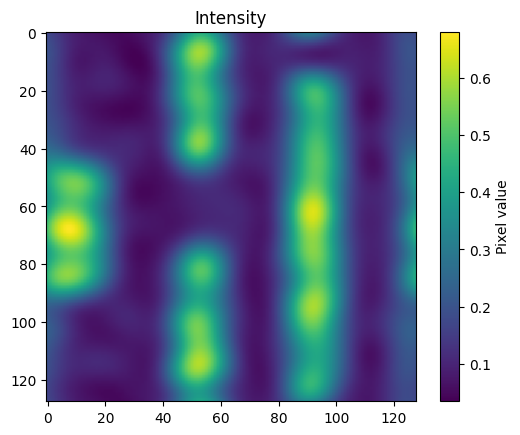

In [22]:
from matplotlib import pyplot as plt
plt.imshow(intensity)
plt.title("Intensity")
plt.colorbar(label="Pixel value")
plt.show()